# **NONLINEAR ANALYSIS OF A SHALLOW TRUSS IN PYTHON**
***

First we do our import statements

In [23]:
from numpy import sqrt
from scipy.optimize import newton, minimize
import matplotlib.pyplot as plt

The following set of parameters constitute a well-behaving problem:

In [2]:
# Units are understood in [kN] and [m]
b = 10.  #  half of the total width of the structure in [m]
h = 0.5  # initial height of the structure in [m]
EA = 5000.  # <Young's modulus> * <Cross sectional area> in [kN/m2]
k = 1.0  # spring stiffness [kN/m]
F = 1.5  # applied load in [kN]

## **EQUILIBRIUM APPROACH**

We use the equilibrium equations to create two residual functions, one for force-controlled and another for displacement-controlled calculations.

### § **FORCE-CONTROLLED ANALYSIS**

The first one looks like:
$$
R(v) = F - k v + K \left( l(v)-l_0 \right) \frac{h-v}{l(v)}
$$

In [3]:
def R(F):
    """
    Returns the residual function R(v). 
    Optimal for a force-controlled analysis, 
    where this function is called in succession 
    for different (probably increasing) load values.
    """
    l0 = sqrt(h**2 + b**2)
    def inner(v):
        l = sqrt((h-v)**2 + b**2)
        return F - k*v + EA*((l-l0)/l0)*((h-v)/l)
    return inner

We also make a version of this with the approximation $l(v) \approx l0$, so that we can observe it's validity on our problem.

In [4]:
def R_(F):
    """
    Returns the residual function R(v). 
    Optimal for a force-controlled analysis, 
    where this function is called in succession 
    for different (probably increasing) load values.
    This version assumes the validity of the 
    approximation |l < l0| << 1.
    """
    l0 = sqrt(h**2 + b**2)
    def inner(v):
        l = sqrt((h-v)**2 + b**2)
        return F - k*v + EA*((l-l0)/l0)*((h-v)/l0)
    return inner

We use `scipy.optimize.newton` to find the roots of our equations. It needs to be fed with a callable object and an initial guess for the result: 

In [5]:
# solution by findig roots of a nonlinear function
v = newton(R(F), 0)
print("A result of F = {} [kN] is the displacement v = {} [m].".format(F, v))
# solution by findig roots of a nonlinear function using the approximation l = l0
v = newton(R_(F), 0)
print("A result of F = {} [kN] is the displacement v = {} [m].".format(F, v))

A result of F = 1.5 [kN] is the displacement v = 1.1696187845864412 [m].
A result of F = 1.5 [kN] is the displacement v = 1.1695310638900063 [m].


In certain circumstances, Newton's method can fail, so we create a wrapper function around `scipy`'s `newton` method that returns `None` if things go wrong during execution.

In [6]:
def root(fnc, x0=0, verbose=False):
    """Returns None if things go wrong, returns the
    root(s) of `fnc`. If `verbose` is `True` and 
    things go wrong, it prints the error message."""
    try:
        return newton(fnc, x0)
    except Exception as e:
        if verbose:
            print(e)
        return None

We apply the force in small steps, and we execute the previous calculation. In every substep, the initial guess is the result of the last substep. We also plot the evolution of the force-displacement diagram using `matplotlib`.

First we prepare the data to plot.

In [7]:
k = 1.0  # overwrite the spring stiffness here if you want
nstep = 20
ydata = [(i+1)*F/nstep for i in range(nstep)]
xdata1, xdata2 = [], []
ydata1, ydata2 = [], []
v1, v2 = 0, 0
v1_, v2_ = 0, 0

for Fi in ydata:
    v1_ = root(R(Fi), v1)
    if v1_:
        v1 = v1_
        xdata1.append(v1)
        ydata1.append(Fi)
    v2_ = root(R_(Fi), v2)
    if v2_:
        v2 = v2_
        xdata2.append(v2)
        ydata2.append(Fi)

Then the plot itself.

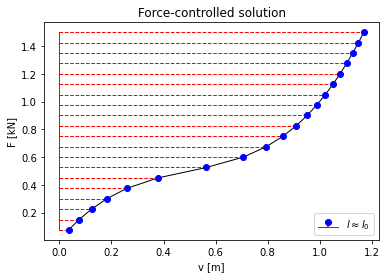

In [8]:
fig, ax = plt.subplots()
ax.plot(xdata1, ydata1, lw=1.0, color='k')
markerline, stemlines, baseline = \
    ax.stem(ydata2, xdata2, basefmt='r-', orientation='horizontal', \
        linefmt='r--', markerfmt='bo', label=r"$l \approx l_0$")
plt.setp(stemlines, 'linewidth', 1)
plt.setp(baseline, 'linewidth', 1) 
ax.set_xlabel('v [m]')
ax.set_ylabel('F [kN]') 
ax.legend()
ax.set_title('Force-controlled solution')
plt.ioff()
plt.show()

The figure shows that approximation $l \approx l0$ does not have a sigificant effect on the results of our model for this particular set of parameters. Try other parameters to investigate other possible scenarios.

### § **DISPLACEMENT-CONTROLLED ANALYSIS**

The difference in the second function is that it considers the displacement to be known and the force to play the role of the unknown, but they basically evaluate the same expression:
$$
Q(F) = F - k v + K \left( l(v)-l_0 \right) \frac{h-v}{l(v)}
$$

In [9]:
def Q(v):
    """
    Returns the residual function Q(F). 
    Optimal for a force-controlled analysis, 
    where this function is called in succession 
    for different (probably increasing) displacement values.
    """
    l0 = sqrt(h**2 + b**2)
    def inner(F):
        l = sqrt((h-v)**2 + b**2)
        return F - k*v + EA*((l-l0)/l0)*((h-v)/l)
    return inner


Again, we can measure the effect of the approximation $l(v) \approx l0$.

In [10]:
def Q_(v):
    """
    Returns the residual function Q(F). 
    Optimal for a force-controlled analysis, 
    where this function is called in succession 
    for different (probably increasing) displacement values.
    his version assumes the validity of the 
    approximation |l < l0| << 1.
    """
    l0 = sqrt(h**2 + b**2)
    def inner(F):
        l = sqrt((h-v)**2 + b**2)
        return F - k*v + EA*((l-l0)/l0)*((h-v)/l0)
    return inner

To find the roots, we use the same facility:

In [11]:
# solution by findig roots of a nonlinear function
F = root(Q(v), 0)
print("The reason of displacement v = {} [m] is the force F = {} [kN].".format(v, F))

The reason of displacement v = 1.1695310638900063 [m] is the force F = 1.4996736875114545 [kN].


In [12]:
#k = 0.0  # overwrite the spring stiffness here if you want
nstep = 20
xdata = [(i+1)*v/nstep for i in range(nstep)]
xdata1, xdata2 = [], []
ydata1, ydata2 = [], []
F1, F2 = 0, 0
F1_, F2_ = 0, 0

for vi in xdata:
    F1_ = root(Q(vi), F1)
    if F1_:
        F1 = F1_
        xdata1.append(vi)
        ydata1.append(F1)
    F2_ = root(Q_(vi), F2)
    if F2_:
        F2 = F2_
        xdata2.append(vi)
        ydata2.append(F2)

A quick plot:

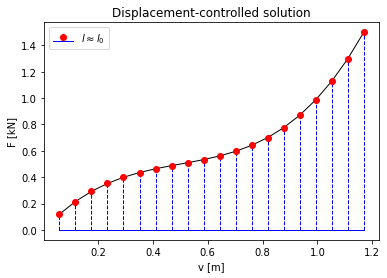

In [13]:
fig, ax = plt.subplots()
ax.plot(xdata1, ydata1, lw=1.0, color='k')
markerline, stemlines, baseline = \
    ax.stem(xdata2, ydata2, basefmt='b-', orientation='vertical', \
        linefmt='b--', markerfmt='ro', label=r"$l \approx l_0$")
plt.setp(stemlines, 'linewidth', 1)
plt.setp(baseline, 'linewidth', 1)
ax.set_xlabel('v [m]')
ax.set_ylabel('F [kN]')
ax.legend()
ax.set_title('Displacement-controlled solution')
plt.show()

### § **AN ERROR MEASURE**

 First we implement the custom error measures $G(v) = R(v)^2$ and $H(F) = Q(F)^2$:

In [14]:
residual1 = R(F)
G = lambda x : residual1(x[0])**2
# for displacement control
residual2 = Q(v)
H = lambda x : residual2(x[0])**2

Then we find the minimum of these using Powell's method presented by `scipy`:

In [15]:
# solution by minimizing an error measure
v = minimize(G, [0], method='Powell', tol=1e-8).x[0]
print("A result of F = {} [kN] is the displacement v = {} [m].".format(F, v))

A result of F = 1.4996736875114545 [kN] is the displacement v = 1.1695310638933072 [m].


In [16]:
# solution by minimizing an error measure
F = minimize(H, [0], method='Powell', tol=1e-8).x[0]
print("The reason of displacement v = {} [m] is the force F = {} [kN].".format(v, F))

The reason of displacement v = 1.1695310638933072 [m] is the force F = 1.4996736875114545 [kN].


Now compare this solution against the previous displacement-controlled one.

In [17]:
#k = 0.0
nstep = 20
xdataG, xdataH = [], [(i+1)*v/nstep for i in range(nstep)]
ydataG, ydataH = [(i+1)*F/nstep for i in range(nstep)], []

v_, F_ = 0, 0
for Fi, vi in zip(ydataG, xdataH):
    ri = R(Fi)
    Gi = lambda x : ri(x[0])**2
    v_ = minimize(Gi, [v_], method='Powell', tol=1e-8).x[0]
    xdataG.append(v_)
    ri = Q(vi)
    Hi = lambda x : ri(x[0])**2
    F_ = minimize(Hi, [F_], method='Powell', tol=1e-8).x[0]
    ydataH.append(F_)


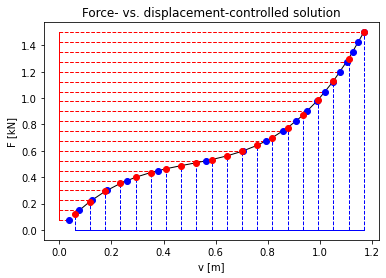

In [18]:
fig, ax = plt.subplots()
ax.plot(xdata2, ydata2, lw=1.0, color='k')
markerlineG, stemlinesG, baselineG = \
    ax.stem(ydataG, xdataG, basefmt='r-', orientation='horizontal', \
        linefmt='r--', markerfmt='bo')
plt.setp(stemlinesG, 'linewidth', 1)
plt.setp(baselineG, 'linewidth', 1)
markerlineH, stemlinesH, baselineH = \
    ax.stem(xdataH, ydataH, basefmt='b-', orientation='vertical', \
        linefmt='b--', markerfmt='ro')
plt.setp(stemlinesH, 'linewidth', 1)
plt.setp(baselineH, 'linewidth', 1)
ax.set_xlabel('v [m]')
ax.set_ylabel('F [kN]')
ax.set_title('Force- vs. displacement-controlled solution')
plt.show()

## **ENERGY APPROACH**

Below there is a simple implementation of the TPE functional
$$
\mathbf{\Pi}(v) = k v^2 + K \Delta l(v)^2 - 2 F v
$$

In [19]:
def TPE(F):
    """
    Returns the function of the total potential energy.
    The returned function takes displacements as inputs
    and returns forces.
    """
    l0 = sqrt(h**2 + b**2)
    K = EA / l0
    def inner(v):
        # v is expected as an iterable
        l = sqrt((h-v[0])**2 + b**2)
        return K*(l-l0)**2 + k*v[0]**2 - 2*F*v[0]
    return inner

To get the minimizer, we can use Powell's method again:

In [20]:
# solution by minimizing an error measure
v = minimize(TPE(F), [0], method='Powell', tol=1e-8).x[0]
print("A result of F = {} [kN] is the displacement v = {} [m].".format(F, v))

A result of F = 1.4996736875114545 [kN] is the displacement v = 1.169531025699906 [m].


We can create a simple plot with `matplotlib`:

In [21]:
#k = 0.
nstep = 20
ydata = [(i+1)*F/nstep for i in range(nstep)]
xdata = []
v = 0
for Fi in ydata:
    v = minimize(TPE(Fi), [v], method='Powell', tol=1e-8).x[0]
    xdata.append(v)

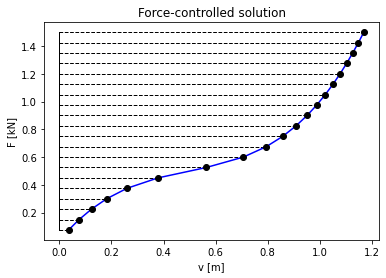

In [22]:
fig, ax = plt.subplots()
ax.plot(xdata, ydata, color='b')    
markerline, stemlines, baseline = \
    ax.stem(ydata, xdata, basefmt='k-', markerfmt='ko', linefmt='k--', \
        orientation='horizontal')
plt.setp(stemlines, 'linewidth', 1)
plt.setp(baseline, 'linewidth', 1)
ax.set_xlabel('v [m]')
ax.set_ylabel('F [kN]')
ax.set_title('Force-controlled solution')
plt.show()

End of Slideshow...